In [44]:
import os
import itertools
import random
from math import log, exp, sqrt, pi

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler


import matplotlib.animation as animation

import numpy as np
from scipy.stats import *
import pandas as pd
import seaborn as sns
import pyro as pyro

import ars as ars

In [2]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':14})
rc('text', usetex=True)
plt.rc('axes', prop_cycle=(cycler('color', ['red', 'gray', 'black', 'blue', 'green'])))#, )))
#plt.rc('axes', prop_cycle=(cycler('color', ["#ba1600","#000000","#646f4b","#839d9a","#7bb2d9"])))


# Algorithm 1
Serial algorithm for BayesW sampling from the posterior distribution $p(\mu, \alpha, \delta, \gamma, \beta, \pi, \sigma_G^2|D)$ .Initialisation and prior speciﬁcation.

__Data__: 
- matrix $x$ of standardised genotypes, size M
- matrix with covariate data $z$, size C
- vector of last time without an event $y$ size L
- vector of failure indicators $d$
- prior hyperparameters , $p_L$ size P:
    - $\alpha_0, \kappa_0$: parameters of the prior distribution of $\alpha$, gamma distribution
    $$ p(\alpha) \propto \alpha^{\alpha_0 -1} \exp(-\kappa_0\alpha)$$
    - $\alpha_{\sigma}, \beta_{\sigma}$: parameters of the $\sigma_G^2$
    - $\sigma^2_{\mu}$: variance parameter of the prior distribution of $\mu$ 
    - $\sigma^2_{\delta}$: variance parameter of the prior distribution of $\delta$
- iterations $I$
- $V_0 , V_1 and V_2$ denote the partial sums of the exponentiated residuals
(deﬁned in Derivations for the sparse calculations)
- K is the Euler-Mascheroni constant.

__Initial values__: Initially, we exclude all the variables from the model.
- $y_j =0 \forall j \in {1,...,M}$. 
- $\beta_j =0 \forall j$ 
- $\sigma_q = 0 \forall q$ 
- $\alpha$: suitably transformed variance of the log sample. 
- $\mu$: mean of the log sample. 
- $\sigma_G^2$: the variance of the log sample divided by the total number of markers M.

__Parameters for prior distributions__: We set priors weakly informative. Otherwise, if
available, prior information could be used. 
- $\alpha$: $\alpha_0 = 0.01, \kappa_0 = 0.01$
- $\sigma^2_G$: $\alpha_{\sigma}=1$ and $\beta_{\sigma} = 0.0001$.
- $\mu$: $\sigma^2_{\mu} = 100$ 
- $\delta_q$:$\sigma^2_{\delta} = 100$
- $\pi$ and $p_L$: vector of ones

## Prior distributions
 prior hyperparameters , $p_L$:
    - $\alpha_0, \kappa_0$: parameters of the prior distribution of $\alpha$, gamma distribution
    $$ p(\alpha) \propto \alpha^{\alpha_0 -1} \exp(-\kappa_0\alpha)$$
    - $\alpha_{\sigma}, \beta_{\sigma}$: parameters of the $\sigma_G^2$
    - $\sigma^2_{\mu}$: variance parameter of the prior distribution of $\mu$ 
    - $\sigma^2_{\delta}$: variance parameter of the prior distribution of $\delta$

Prior distribution of $\alpha$: gamma distribution with parameters $\alpha_0, \kappa_0$.

$$ p(\alpha) \propto \alpha^{\alpha_0 -1} \exp(-\kappa_0\alpha)$$

Prior for $\beta_j$ follow a normal distribution with variance parameter $\sigma^2_G$

$$p(\beta_j|\sigma^2_G, y_j=k) \propto \left(\frac{1}{C_k\sigma_G^2}\right)^2 \exp(-\frac{1}{2C_k\sigma_G^2}\beta_j^2)$$

Prior of $\sigma^2_G$ follow a inverse gamma distribution with parameters $\alpha_{\sigma}, \beta_{\sigma}$

$$p(\sigma^2_G)\propto \left(\frac{1}{\sigma^2_G}\right)^{\alpha_{\sigma} +1}\exp\left(-\frac{\beta_{\sigma}}{\alpha_{\sigma}}\right)$$ 

Prior of $\delta_q$ (effect of the covariate q) is a normal with variance $\sigma^2_{\delta}$:

$$p(\delta_q\propto  \exp\left(-\frac{1}{2\sigma^2_{\delta}}\delta_q^2\right)$$

Prior of $\mu$ is a normal distribution with variance $\sigma^2_{\mu}$

$$p(\mu\propto  \exp\left(-\frac{1}{2\sigma^2_{\mu}}\mu^2\right)$$

The prior for $y_j$ is a multinomial distribution

$$p(y_j|\pi)\propto = \pi_0^{I(y_j=0)}\cdot...\cdot \pi_L^{I(y_j=L)}$$

The prior probabilities of belonging to each of the mixture distributions k are stored in L+1 dimensional vector $\bf\pi$ with the prior for $\bf\pi$ a Dirichlet distribution

$$ p(\pi) \propto Dirichlet(p_L)$$

where $I(\cdot)$ is the indicator function and $p_L$ is the L+1 dimensional vector with prior values. 




In [3]:
#data
n_markers = 100 #number M of markers
n_samples = 100 #number of individuals (times to event)
n_covs = 10 #number of covariates
l_mix = 4 #mixture components
max_iter = 1000

#simulated data
markers = np.random.binomial(2, 0.5, size = (n_samples, n_markers)) #x matrix of markers
cov = np.random.binomial(1, 0.5, size = (n_samples, n_covs)) #z matrix of 
d_fail = np.random.choice([0,1], n_samples,)

Having the matrix M of genotypes then we can calculate the partial sums for each genotype

Initial values for the parameters:
- mu is the intercept (time to event) $\mu$
- betas are the effects of the markers $\beta_j$ for j marker
- deltas are the effects of the covariates $\delta_q$ for q covariate
- gammas are the mixture indicators of the markers $\gamma_j$ for j marker

In [4]:
#initial values
betas = np.zeros(n_markers)
deltas = np.zeros(n_covs)
gammas = np.zeros(n_markers)
d = np.sum(d_fail)


We define the parameters for the priors of the parameters

In [5]:
#priors of parameters
alpha_zero = 0.01
kappa_zero = 0.01
alpha_sigma = 1
beta_sigma = 0.0001
var_mu = 100
var_delta = 100
pi_vector = np.zeros(l_mix) + 1
hyperparameters = np.zeros(l_mix +1)


Log posteriors:

\begin{align}
& \log p(\mu|D, \alpha, \beta, \delta) = \\
& c - \alpha \mu d + \exp(-K) \sum^n_{i=1}\exp (-\alpha(log(y_i)-\mu - x'_i\beta - z'_i\delta)) - \frac{1}{2\sigma^2_{\mu}}\mu^2 
\end{align}

In [47]:
#parameter dictionary
pars = {}

We draw samples from a gumbel distribution to obtain the log of the time-to-event data. First we sample from a uniform the location and shape parameters of a Weibull distribution. 

In [48]:
weibull_pars = (np.random.uniform(), np.random.uniform())
pars["gumbel_loc"] = -log(weibull_pars[1])
pars["gumbel_scale"] = 1/weibull_pars[0]

If Y follow a Weibull distribution with parameters $Y \sim W(a, b)$ being $a$ the location parameter and $b$ the scale parameter, then $log Y \sim G(\mu, \sigma)$ being $\mu, \sigma$ the location and scale parameters of the Gumbel distribution. We can do a re-parametrization of the distribution so that

$$\mu = -log(b), \quad \sigma = \frac{1}{a}$$

The mean of the Gumbel distribution is given by 

$$E(log Y) = \mu + \sigma K = -log(b) + \frac{K}{a}$$
$$Var(log Y) =  \frac{\sigma^2 \pi^2}{6} = \frac{\pi^2}{6 a^2} $$

In the paper it is written as

$$E(log Y) = log(b) - \frac{K}{a}$$

So its multiplied by -1 (I dont know where this comes from)


References: https://www.utstat.toronto.edu/~brunner/oldclass/312s19/lectures/312s19WebullGumbel.pdf
https://www.itl.nist.gov/div898/handbook/eda/section3/eda366g.htm


Text(0, 0.5, 'PDF(x)')

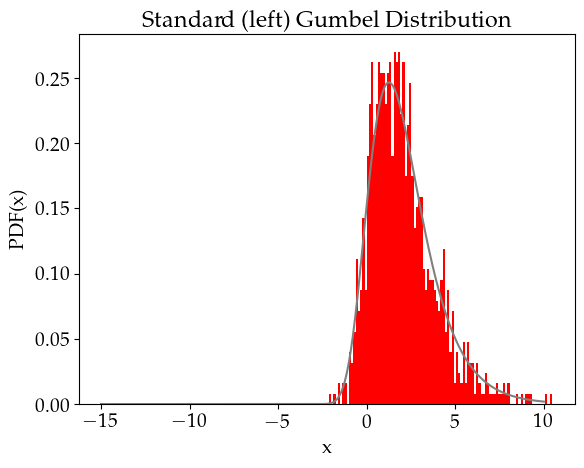

In [49]:
gumbel_dis = gumbel_r(loc=pars["gumbel_loc"], scale=pars["gumbel_scale"])

# Generate data points
x = np.linspace(-15, 10, num=1000)

# Create Gumbel distribution object
gumbel_data = gumbel_dis.rvs(size=1000)

# Calculate PDF of Gumbel distribution for each data point
pdf = gumbel_dis.pdf(x)

# Plot the PDF of the Gumbel distribution
plt.hist(gumbel_data, density=True, bins=100)
plt.plot(x, pdf)
plt.title('Standard (left) Gumbel Distribution')
plt.xlabel('x')
plt.ylabel('PDF(x)')


We calculate the sample mean, the built-in function, and the expected value by using the equation in the previous block

In [50]:
gumbel_mean = pars["gumbel_loc"] + np.euler_gamma*pars["gumbel_scale"]
np.mean(gumbel_data), gumbel_dis.mean(), gumbel_mean

(2.021398829417085, 2.1142975808510474, 2.1142975808510474)

Close enough 

In [51]:
y_data_log = gumbel_dis.rvs(size=100)
mu = np.mean(y_data_log)
residuals = y_data_log - mu

In [52]:
alpha = np.pi/sqrt( 6*np.sum( (y_data_log-mu) **2) / (len(y_data_log)-1))

In [53]:
sigma_g = (pi ** 2/6*(alpha**2))/n_markers

Here in the paper says number of markers but I actually think its the number of mixture groups. Its defined as:

`// Use h2 = 0.5 for the inital estimate// divided  by the number of groups`

`sigmaG.array() = PI_squared/ (6 * pow(used_data_beta.alpha,2))/numGroups;`


Prior of intercept

In [55]:
f_mu = ars.log_gaussian(0, var_mu)

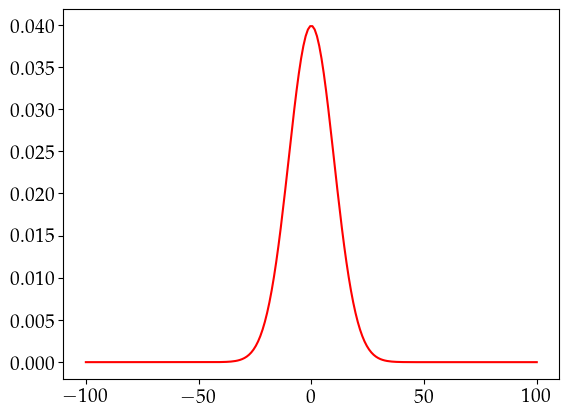

In [56]:
x_arr = np.linspace(-100,100,200)
plt.plot(x_arr, [np.exp(f_mu(x))/ (2 * np.pi*var_mu) ** 0.5 for x in x_arr])

Define the log likelihood and the derivative

In [15]:
def log_mu(pars, epsilon_arr):
    '''computes the log-likelihood of the mu parameters'''
    return lambda x : (-pars['alpha']*x*pars['d'] - np.sum(np.exp((epsilon_arr - x)*pars['alpha'] -np.euler_gamma)) - (x**2)/(2*pars["var_mu"]))

def dev_log_mu(pars, epsilon_arr):
    '''computes the derivative of the log-likelihood of the mu parameters'''
    return lambda x : (-pars['alpha']*pars['d'] + pars['alpha']*np.sum(np.exp((epsilon_arr - x)*pars['alpha'] -np.euler_gamma)) - x/pars["var_mu"])



set up the initial parameter values

In [58]:
alpha = np.pi/sqrt( 6*np.sum( (y_data_log-mu) **2) / (len(y_data_log)-1))

In [59]:
pars = {"alpha":  alpha, #shape parameter of Weibull
        "d": d, #sum of failure indicator
        "var_mu": var_mu} #initial variance

In [66]:
pars

{'alpha': 0.6706786263232083, 'd': 50, 'var_mu': 100}

In [54]:
epsilon = residuals + mu

We only need this three parameters for now

In [61]:
f_mu = log_mu(pars, epsilon)
df_mu = dev_log_mu(pars, epsilon)

Posterior density function

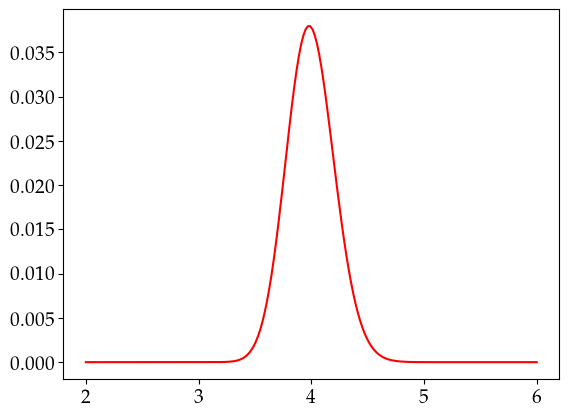

In [72]:
x_arr = np.linspace(2,6,200)
probs = [np.exp(f_mu(x)) for x in x_arr]
plt.plot(x_arr, probs/np.sum(probs))


In [70]:
print("Our mean: ", gumbel_mean)

Our mean:  2.1142975808510474


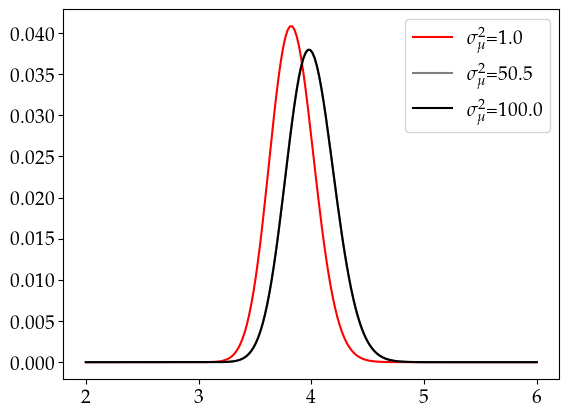

In [82]:
for i in np.linspace(1,100, 3):
    pars["var_mu"] = i
    f_mu = log_mu(pars, epsilon)
    df_mu = dev_log_mu(pars, epsilon)
    x_arr = np.linspace(2,6,200)
    probs = [np.exp(f_mu(x)) for x in x_arr]
    plt.plot(x_arr, probs/np.sum(probs), label=r"$\sigma^2_{\mu}$=%s" %i)

plt.legend()

In [83]:
pars["var_mu"] = 100

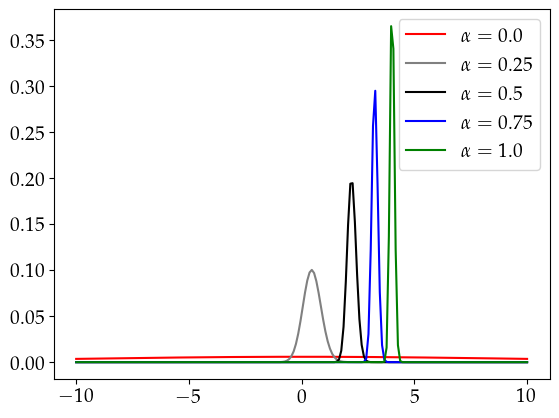

In [87]:
for i in np.linspace(0,1,5):
    pars["alpha"] = i
    f_mu = log_mu(pars, epsilon)
    df_mu = dev_log_mu(pars, epsilon)
    x_arr = np.linspace(-10,10,200)
    probs = [np.exp(f_mu(x)) for x in x_arr]
    plt.plot(x_arr, probs/np.sum(probs), label = r"$\alpha = {}$".format(i))

plt.legend()

In [88]:
pars["alpha"] = alpha

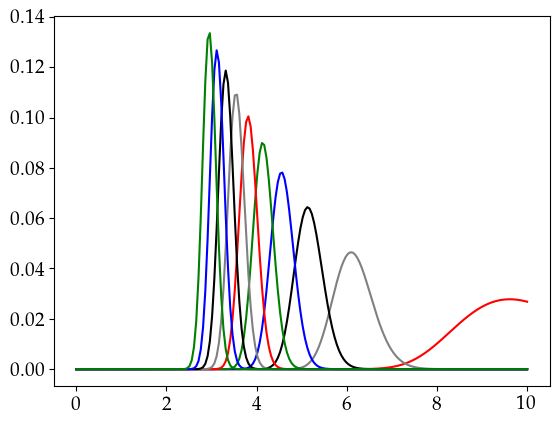

In [90]:
for i in np.linspace(1,100, 10):
    pars["d"] = i
    f_mu = log_mu(pars, epsilon)
    df_mu = dev_log_mu(pars, epsilon)
    x_arr = np.linspace(0,10,200)
    probs = [np.exp(f_mu(x)) for x in x_arr]
    plt.plot(x_arr, probs/np.sum(probs), label = "d = {}$".format(i))


In [92]:
pars["d"] = d

Derivative of the function

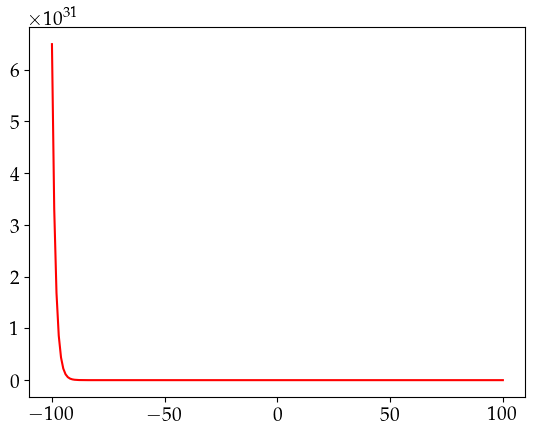

In [91]:
x_arr = np.linspace(-100,100,200)
dprobs = [df_mu(x) for x in x_arr]
plt.plot(x_arr, dprobs)

To the sampler...

We initialize the abscissa with 100 points (the bounds dont do anything now)

In [96]:
xs, hs, dhdxs = ars.initialise_abcissa(mu, f_mu, df_mu, 200, bounds=(0.8*mu, 1.2*mu))

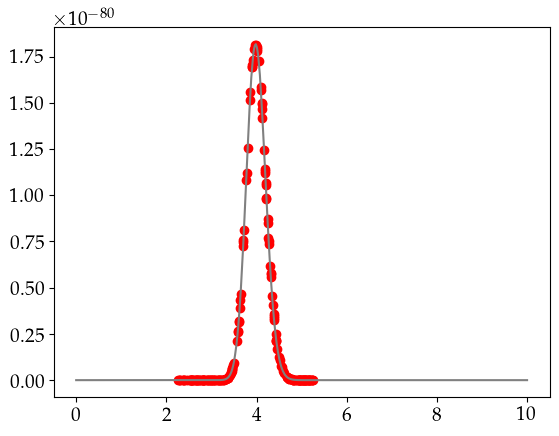

In [97]:
x_plot = np.linspace(0, 10, 1000)

gu_abs = [ars.g_u(x, xs, hs, dhdxs) for x in x_plot]

plt.plot(xs, ars.g_u(xs, xs, hs,dhdxs), "o")

plt.plot(x_plot, gu_abs)

The bounds in here are used just for the sampler. The take values that are in the interval (we set the probability of the rest of the intervals to 0).

In [103]:
maxit = 100
num_samples = 1
## our start guess is mu
mu = np.mean(y_data_log)
epsilon = y_data_log - mu

x0, num_samples = mu, 1
sampled_means = [mu]
epsilon_array = [epsilon]
N = len(y_data_log)
bounds_arr = []

for it in range(maxit):
    epsilon = epsilon + mu
    bounds = (0.9*mu, 1.1*mu)
    bounds_arr.append(bounds)
    x0, num_samples = mu, 1
    
    f_mu = log_mu(pars, epsilon)
    df_mu = dev_log_mu(pars, epsilon)

    samples, xs = ars.adaptive_rejection_sampling(x0=x0, log_unnorm_prob=f_mu, derivative= df_mu, num_samples=num_samples, bounds = bounds)
    
    mu = samples[0]
    
    sampled_means.append(mu)
    epsilon = epsilon - mu

In [104]:
bounds_arr = np.array(bounds_arr)

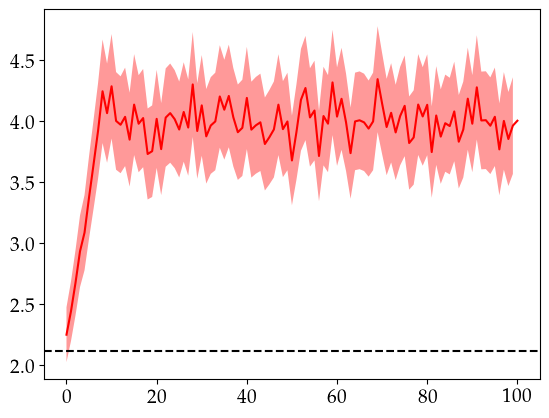

In [105]:
plt.close()
plt.plot(sampled_means)
plt.axhline(y=gumbel_mean, linestyle= "--", color="k")
plt.fill_between(range(0,maxit), y1=bounds_arr[:,0], y2=bounds_arr[:,1], alpha=0.4)
plt.show()

It's not that different but still we dont retrieve our mean at all

Until here is enough i think, the others are previous tests I did

Sampler without bounds

In [19]:
maxit = 100
num_samples = 1
## our start guess is mu
mu = np.mean(y_data_log)
epsilon = y_data_log - mu

x0, num_samples = mu, 1
sampled_means = [mu]
epsilon_array = [epsilon]
N = len(y_data_log)
bounds = (float("-inf"), float("inf"))

for it in range(maxit):
    
    epsilon = epsilon + mu
    
    x0, num_samples = mu, 1

    f_mu = log_mu(pars, epsilon)
    df_mu = dev_log_mu(pars, epsilon)

    samples, xs = ars.adaptive_rejection_sampling(x0=x0, log_unnorm_prob=f_mu, derivative= df_mu, num_samples=num_samples, bounds=bounds)
    mu = samples[0]
    sampled_means.append(mu)
    epsilon = epsilon - mu

TypeError: adaptive_rejection_sampling() got an unexpected keyword argument 'bounds'

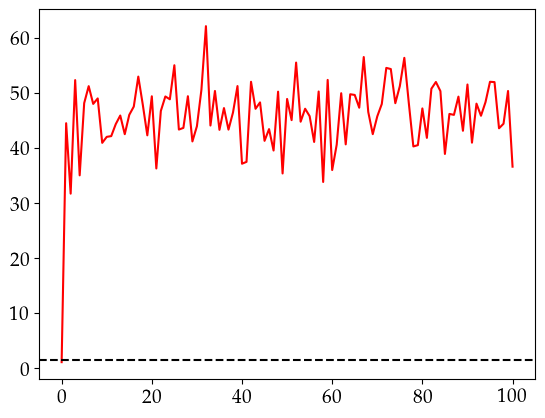

In [16]:
plt.close()
plt.plot(sampled_means)
plt.axhline(y=gumbel_mean, linestyle= "--", color="k")
plt.show()

Sampler with bounds and adding points between the bounds (flexible case). This means that i dont completely restrict to the bounds, but I take the intervals that are more proximate.

In [41]:
maxit = 100
num_samples = 1
## our start guess is mu
mu = np.mean(y_data_log)
epsilon = y_data_log - mu

x0, num_samples = mu, 1
sampled_means = [mu]
epsilon_array = [epsilon]
N = len(y_data_log)

for it in range(maxit):
    
    if mu > 0:
        bounds = (0.9*mu, 1.1*mu)
    else:
        bounds = (1.1*mu, 0.9*mu )
    
    epsilon = epsilon + mu
    
    x0, num_samples = mu, 1

    f_mu = log_mu(pars, epsilon)
    df_mu = dev_log_mu(pars, epsilon)

    samples, xs = ars.adaptive_rejection_sampling(x0=x0, log_unnorm_prob=f_mu, derivative= df_mu, num_samples=num_samples, bounds=bounds)
    mu = samples[0]
    sampled_means.append(mu)
    epsilon = epsilon - mu



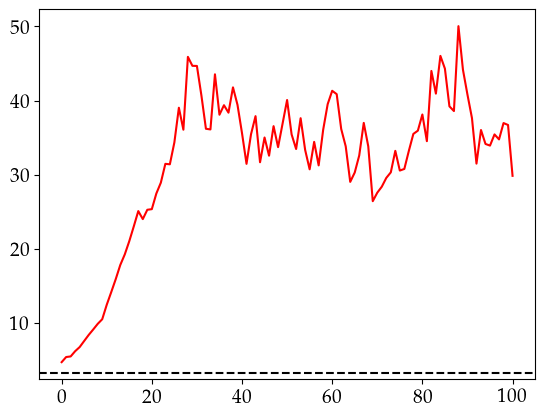

In [42]:
plt.close()
plt.plot(sampled_means)
plt.axhline(y=gumbel_mean, linestyle= "--", color="k")
plt.show()

In [39]:
bounds_arr = np.array(bounds_arr)

In [92]:
%matplotlib ipympl

In [93]:
# importing required libraries
  
N = len(epsilon_array)
# initializing a figure
fig = plt.figure()
  
# labeling the x-axis and y-axis
axis = plt.axes(xlim=(-100, 100),  ylim=(0, 0.2))

# initializing a line variable
line, = axis.plot([], [], lw=3)
  
def animate(frame_number, params):
    x = np.linspace(-100, 100, 100)
    
    f_mu = log_mu(pars, params[frame_number])
    
    probs = [frame_number + np.exp(f_mu(xi)) for xi in x]
    y = probs/np.sum(probs)
    
    line.set_data(x, y)
    line.set_color('red')
    return line,

plt.close()
  
anim = animation.FuncAnimation(fig, animate, frames=N, 
                               interval=2, blit=True,
                               fargs = (epsilon_array,))

fig.suptitle('Posterior', fontsize=14)
  
plt.show()


In [94]:
plt.close()

In [95]:
def log_alpha(pars, epsilon_arr):
    '''computes the log-likelihood of the alpha parameter'''
    return lambda x : (pars['alpha0'] + pars['d'] - 1) *np.log(x) - x * (np.sum((epsilon * pars["failure_v"])) - pars["kappa0"]) - np.sum(np.exp((epsilon * x) -np.euler_gamma))

def dev_log_alpha(pars, epsilon_arr):
    '''computes the derivative of the log-likelihood of the alpha parameter'''
    return lambda x : (-pars['alpha']*pars['d'] + pars['alpha']*np.sum(np.exp((epsilon - x)*pars['alpha'] -np.euler_gamma)) - x/pars["var_mu"]) 
    



In [96]:
mu = Parameter(log_mu, dev_log_mu)

TypeError: __init__() missing 1 required positional argument: 'bounds'

In [61]:
class Parameter:
    def __init__(self, log_dens_f, log_dens_fdev, bounds):
        self.current_value = None
        self.previous_values = []
        self.log_dens_f = log_dens_f
        self.log_dens_f = log_dens_fdev
        

    def sample_posterior(self, params, epsilon, n_samples=1, val_bounds = (0.8, 1.2)):
        bounds = (val_bounds[0]*self.current_value, val_bounds[1]*self.current_value)
        self.previous_values.append(self.current_value)
        f_mu = self.log_dens_f(params, epsilon)
        df_mu = self.log_dens_f(params, epsilon)
        samples, xs = ars.adaptive_rejection_sampling(x0=x0, log_unnorm_prob=f_mu, derivative= df_mu, num_samples=n_samples, bounds=bounds)
        if n_samples == 1:
            self.current_value = samples[0]
        else:
            self.current_value = samples

        return self.current_value
        """"""
    
    def get_value(self):
        return self.current_value
    
    def likelihood(self, data):
        """"""
    def log_prior(self):
        """"""

## SAMPLER

With only one sample...

In [145]:
x0, num_samples = mu, 1
samples, xs = ars.adaptive_rejection_sampling(x0=x0, log_unnorm_prob=f_mu, derivative= df_mu, num_samples=num_samples)
len(xs)

7

''

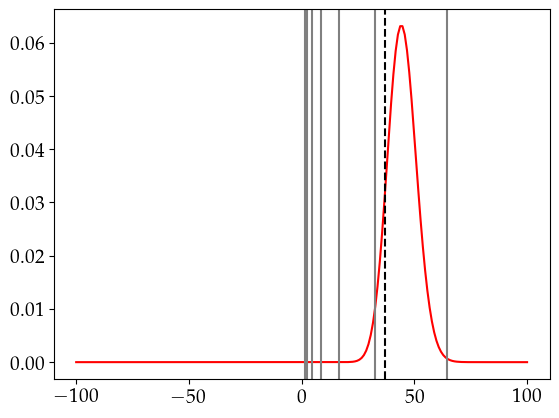

In [146]:
probs = np.array([np.exp(f_mu(x)) for x in x_arr])
plt.plot(x_arr, probs/np.sum(probs))
for xc in xs:
    plt.axvline(x = xc, color="gray")
    
plt.axvline(x = samples[0], linestyle="--", color="k")
;

With 100 samples...

In [46]:
x0, num_samples = mu, 100
samples, xs = ars.adaptive_rejection_sampling(x0=x0, log_unnorm_prob=f_mu, derivative= df_mu, num_samples=num_samples)
len(xs)

14

''

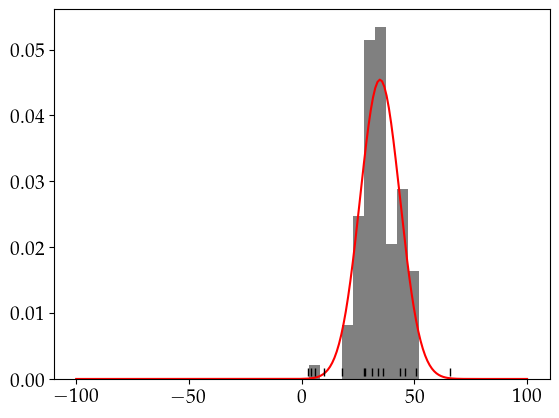

In [49]:
probs = np.array([np.exp(f_mu(x)) for x in x_arr])
plt.plot(x_arr, probs/np.sum(probs))
plt.hist(samples, density=True)
plt.plot(xs, np.repeat(0.001,len(xs)), "|")
;

With 100 samples and only taking the last one... We repeat this a 100 times and do the histogram

''

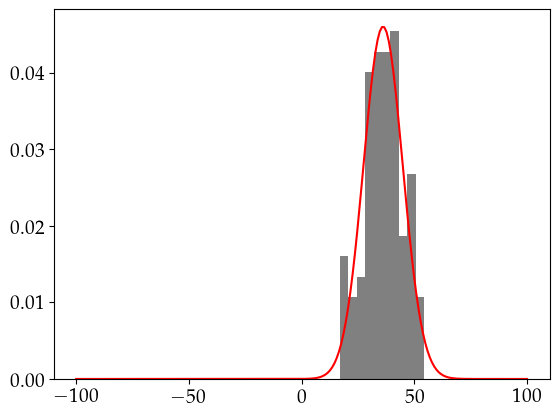

In [121]:
s = []
for i in range(100):
    x0, num_samples = mu, 100
    samples = ars.adaptive_rejection_sampling(x0=x0, log_unnorm_prob=f_mu, derivative= df_mu, num_samples=num_samples)
    s.append(samples[-1])
probs = np.array([np.exp(f_mu(x)) for x in x_arr])
plt.plot(x_arr, probs/np.sum(probs))
plt.hist(s, density=True)
;

Its not better than the previous one

## Questions

Is dividing alpha by the sample size ok?
There is a minus in the formula of the paper but not in the implemented version. It works without the minus, but is this okay?

In [ ]:
class Parameter:
    def __init__(self, dis_parameters, log_dens_f, log_dens_fdev):
        self.distribution_parameters = dis_parameters
        self.current_value = None
        self.previous_values = []

    def sample_prior(self):
        """"""
    def sample_posterior(self, data):
        """"""
    
    def likelihood(self, data):
        """"""
    def log_prior(self):
        """"""

In [8]:
def univariate_normal(x, mean=0, variance=var_mu):
    """pdf of the univariate normal distribution."""
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

In [9]:
def normal_to_lognormal(mu, var):
    """
    Convert parameters of a normal distribution to parameters of a lognormal distribution.

    Parameters:
        mu (float): Mean of the normal distribution.
        var(float): var of the normal distribution.

    Returns:
        A tuple (lognormal_mu, lognormal_var) containing the mean and standard deviation of the corresponding lognormal distribution.
    """
    lognormal_mu = np.exp(mu + var/2)
    lognormal_var = np.exp(2*var)*(np.exp(var)-1)*np.exp(2*mu)
    return lognormal_mu, lognormal_var

In [10]:
def lognormal(x, var_normal):
    args = normal_to_lognormal(0, np.sqrt(var_normal))
    var = args[1]**2
    mean = args[0]
    return((1. /x*np.sqrt(2*np.pi*var))*np.exp(-(np.log(x)-mean)**2/(2*var)))

In [11]:
def gaussian_logpdf(x, args=normal_to_lognormal(0, var_mu)):
    return (1/(x*np.sqrt(2*np.pi*args[1])))*np.exp(-((np.log(x)-args[0])**2)/(2*args[1]))

In [12]:
import ars as ars

In [13]:
log_prob = ars.log_gaussian(0, 100)

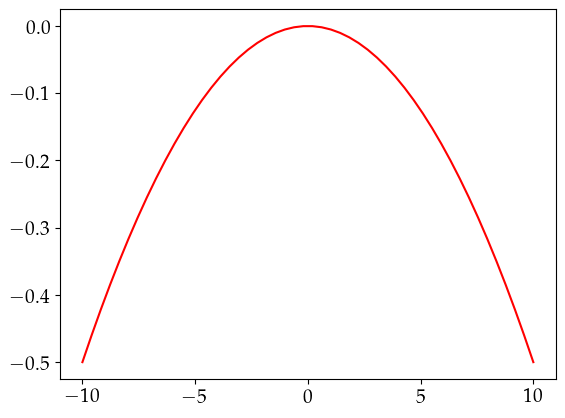

In [14]:
x = np.linspace(-10,10)
plt.plot(x, log_prob(x)[0])

In [22]:
target_mean = 0.
target_variance = 100.

x0 = 0.95*mu
num_samples = 1
lims = (0.8*mu, 1.1*mu)
log_prob = ars.log_gaussian(mean=target_mean, variance=target_variance)

In [23]:
# Points in the abcissa set and corresponding log-probabilities and gradients
xs = np.array([0.95*mu, mu, 1.005*mu, 1.01*mu])
hs, dhdxs = log_prob(xs)

''

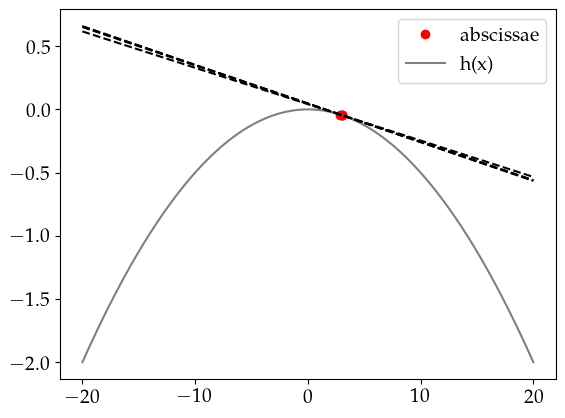

In [24]:
plt.plot(xs, hs, "o", label="abscissae")
x = np.linspace(-20,20,200)
plt.plot(x, log_prob(x)[0], label="h(x)")
for c in range(len(xs)):
    plt.plot(x, dhdxs[c]*(x-xs[c]) + hs[c], "k--")
plt.legend()
;

In [25]:
# Locations to plot the log unnorm. density and envelope/squeezing functions
x_plot = np.linspace(-100, 100, 200)
log_probs = [log_prob(x)[0] for x in x_plot]
gu = [ars.g_u(x, xs, hs, dhdxs) for x in x_plot]
gl = [ars.g_l(x, xs, hs) for x in x_plot]

Text(0.5, 1.0, 'Squeezing function')

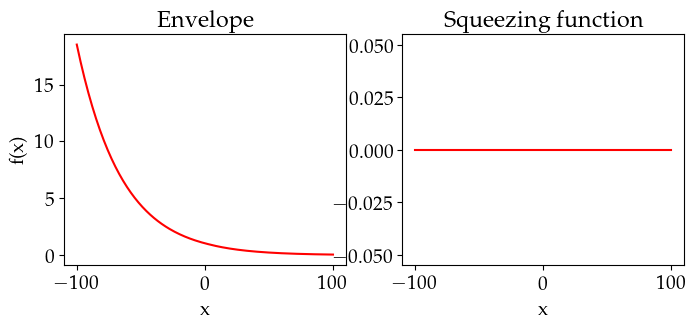

In [26]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x_plot, gu)
plt.ylabel("f(x)")
plt.xlabel("x")
plt.title("Envelope")

plt.subplot(1,2,2)
plt.plot(x_plot, gl)
plt.xlabel("x")
#plt.ylim(np.min(gu), np.max(gu))
plt.title("Squeezing function")

In [21]:
ars.adaptive_rejection_sampling(x0, log_unnorm_prob, num_samples, lims)

ValueError: probabilities are not non-negative

In [ ]:
#gaussian_logpdf = lambda x, sigma=args[1]: np.log(np.exp(-x ** 2 / sigma))
a, b = 2,5  # a < b must hold
domain = (float(0), float("inf"))
n_samples = 10000
samples = ars.adaptive_rejection_sampling(logpdf=gaussian_logpdf, a=a, b=b, domain=domain, n_samples=n_samples)

In [ ]:
def inverse_gamma_dist(x, alpha, beta):
    """pdf of gamma distribution with parameters alpha and beta"""
    return ((beta**alpha/gamma(alpha))*((1/x)**(alpha + 1))*np.exp(-beta/x))

First we define the array of errors of length N (number of individuals) as 

$$\epsilon_i = y_i -\mu$$

So we substract the sample mean (defined as the mean of the log sample) to each of the data components (time to event for each individual)

_Are the time to event data points in log or normal scale? Because we are substracting the log of the mean, and the Gumbel distribution takes the log of Y_

In [ ]:
residuals = y_data - mu

We do the following process for every iteration

In [ ]:
def lognormal_mu(x, sigma=var_mu):
        return np.log(np.exp(-x ** 2 / sigma))

fist we sample the intercept

In [ ]:
var_mu = 100

In [ ]:
old_residuals = residuals

residuals = old_residuals + mu

domain = (float(0), float("inf"))
n_samples = 1000
samples = ars.adaptive_rejection_sampling(logpdf=lognormal_mu, a=2, b=5, domain=domain, n_samples=n_samples)
mu = np.mean(samples)
residuals = residuals - mu




In [ ]:
plt.hist(samples, density=True, bins=100)
;

sample of delta for each covariate

In [ ]:
def lognormal_delta(x, sigma=var_delta):
    return np.log(np.exp(-x ** 2 / sigma))

In [ ]:
residuals = residuals + cov[:,0]*deltas[0]
samples = ars.adaptive_rejection_sampling(logpdf=lognormal_delta, a=2, b=5, domain=domain, n_samples=n_samples)


In [ ]:
plt.hist(samples, density=True, bins=100)
;